In [1]:
import sys
sys.path.append('../..')
import json
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

# PyTorch
import torch.nn as nn
from torch import cuda
from torchvision.models.mobilenet import mobilenet_v2

# DLBio
from DLBio import pt_training
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
from DLBio.pytorch_helpers import get_device, get_num_params

# own scripts
import ds_ear
from classification_test import TestMyModel

In [2]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()

In [3]:
class Config():
    # influences learning rate, weight decay, data folder path and training classes
    IS_OWN_DATASET = True
    # define constants
    LEARNING_RATE = (0.001, 0.0001)[IS_OWN_DATASET] # FORM: (AMI, dataset)  # ORIGINAL
    LEARNING_RATE = (0.001, 0.001)[IS_OWN_DATASET] # FORM: (AMI, dataset)
    WEIGHT_DECAY = (0.0001, 0.1)[IS_OWN_DATASET] # FORM: (AMI, dataset) # ORIGINAL
    WEIGHT_DECAY = (0.0001, 0.1)[IS_OWN_DATASET] # FORM: (AMI, dataset)
    DATASET_DIR = ('../AMI', '../dataset_low_res')[IS_OWN_DATASET]
    CLASSES = (100, 10)[IS_OWN_DATASET]
    BATCH_SIZE = 32
    NUM_WORKERS = 3
    EPOCHS = 15

    FOLDER = './class_sample'
    OPT_TYPE = 'Adam'
    LR_STEPS = 3
    DO_EARLY_STOPPING = True
    STOP_AFTER = 10
    ES_METRIC = 'val_acc'
    SAVE_INTERVALL = -1
    PRINT_FREQUENCY = 500 # print every 500 batches
    SEED = 0

# use seeds to ensure comparable results ()
# pt_training.set_random_seed(SEED)
# np.random.seed(SEED)

model = mobilenet_v2(pretrained=True)
# Remap the classification layer to the correct amount of classes
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=Config.CLASSES)

In [4]:
# for param in model.parameters():
#     param.requires_grad = True

# from DLBio.pytorch_helpers import get_num_params
# get_num_params(model,True)

In [4]:
# freezes all mobilenet parameters except classifier
for param in model.features.parameters():
    param.requires_grad = False

from DLBio.pytorch_helpers import get_num_params
get_num_params(model,True)

12810

In [ ]:
# alternative for freezing all param except classifier
# count = 0
# for child in model.children():
#     count += 1
#     if count < 2:
#         for param in child.parameters():
#             param.requires_grad = False
#     if count == 2:
#         c = child

# from DLBio.pytorch_helpers import get_num_params
# get_num_params(model,True)

In [5]:
device = get_device()
# device = 'cpu'
print(device)
model.to(device)

# define folder to save model and log file
check_mkdir(Config.FOLDER, is_dir=True)
model_out = join(Config.FOLDER, 'model.pt')
log_file = join(Config.FOLDER, 'log.json')

cuda:0


In [6]:
# write some model specs
with open(join(Config.FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

# define indicies to split Data
N = len(ds_ear.get_dataset(Config.DATASET_DIR, transform_mode='size_only'))
n_80 = int(round(.8*N))
n_60 = int(round(.6*N))
n_20 = int(round(.2*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_60]
# valid_indices = rand_indices[n_60:]
valid_indices = rand_indices[n_60:n_60+n_20]
test_indices = rand_indices[n_60+n_20:]

# definde data loader
dl_train = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=train_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='train'
)

dl_valid = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=valid_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='valid_and_test'
)

dl_test = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=test_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='valid_and_test'
)

print(dl_train.dataset.classes, '\n', len(dl_train.dataset.classes), ' classes')

# with open('test_indizes.txt', 'w') as file:
#     for idx in test_indices:
#         file.write("%i\n" % idx)

['falco_len', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe'] 
 10  classes


In [7]:
# define optimizer
optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )

if Config.LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            Config.LR_STEPS, Config.EPOCHS, optimizer)

if Config.DO_EARLY_STOPPING:
    assert Config.SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            Config.ES_METRIC, get_max=True, epoch_thres=Config.STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(Config.PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=Config.SAVE_INTERVALL,
        val_data_loader=dl_valid,
        early_stopping=early_stopping
    )

training(Config.EPOCHS)

Sched step size: 5
Ep: 0, loss: 2.35839 acc: 0.135 lr: 0.00100 sec: 3.78
saving model: ./class_sample/model.pt
Ep: 0, val_loss: 2.24130 val_acc: 0.100 lr: -1.00000 sec: 0.58
Ep: 1, loss: 2.04873 acc: 0.269 lr: 0.00100 sec: 3.60
saving model: ./class_sample/model.pt
Ep: 1, val_loss: 2.06228 val_acc: 0.325 lr: -1.00000 sec: 0.56
Ep: 2, loss: 1.86379 acc: 0.408 lr: 0.00100 sec: 3.60
Ep: 2, val_loss: 1.97505 val_acc: 0.319 lr: -1.00000 sec: 0.58
Ep: 3, loss: 1.66592 acc: 0.533 lr: 0.00100 sec: 3.57
saving model: ./class_sample/model.pt
Ep: 3, val_loss: 1.88344 val_acc: 0.362 lr: -1.00000 sec: 0.55
Ep: 4, loss: 1.54005 acc: 0.560 lr: 0.00100 sec: 3.56
saving model: ./class_sample/model.pt
Ep: 4, val_loss: 1.70179 val_acc: 0.425 lr: -1.00000 sec: 0.56
Ep: 5, loss: 1.46130 acc: 0.598 lr: 0.00010 sec: 3.55
saving model: ./class_sample/model.pt
Ep: 5, val_loss: 1.66375 val_acc: 0.506 lr: -1.00000 sec: 0.55
Ep: 6, loss: 1.41079 acc: 0.660 lr: 0.00010 sec: 3.57
saving model: ./class_sample/model.

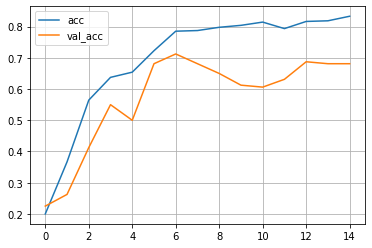

In [8]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')
plt.legend()
plt.grid()

In [ ]:
# # Execute this cell if you want the current variables to be added to the csv-file
# import csv

# with open(log_file, 'r') as file:
#     log = json.load(file)
#     ACC = log['acc']
#     VAL_ACC = log['val_acc']

# with open('var_log.csv', 'a') as f:
#     writer = csv.writer(f, delimiter=',', lineterminator='\n')
#     writer.writerow([
#         Config.DATASET_DIR.split('/')[1],        
#         Config.LEARNING_RATE,
#         Config.WEIGHT_DECAY,
#         Config.CLASSES,
#         Config.OPT_TYPE,
#         Config.EPOCHS,
#         Config.LR_STEPS,
#         Config.DO_EARLY_STOPPING,
#         Config.STOP_AFTER,
#         Config.SEED,
#         Config.BATCH_SIZE,
#         Config.NUM_WORKERS,
#         # saves a list of len(EPOCHS) with accuracies
#         ACC,
#         VAL_ACC,
#         # insert optional comment
#         ""
#     ])
# f.close()



In [ ]:
test = TestMyModel(dl_test, Config.FOLDER)

test.load_model()
test.start_testing()
test.class_acc()